In [4]:
using POMDPs, POMDPGym, Crux, Distributions, BSON, GridInterpolations, LinearAlgebra
using BSON: @save
using StatsFuns
using Random
using PGFPlots
using Colors, ColorSchemes

In [6]:
resetPGFPlotsPreamble()
include("/home/smkatz/Documents/Util/support_code.jl");

In [7]:
include("../../src/multilevel_estimation.jl")
include("../../src/montecarlo.jl")
include("../../src/gaussian_process.jl")
include("../../src/bandit.jl")
include("../../src/kernel_bandit.jl")
include("../../src/learning_bandit.jl")
include("../../src/pspec_bandit.jl")
include("controller.jl")
include("setup.jl")

pendulum_problem (generic function with 1 method)

# Load in Ground Truth

In [8]:
function pendulum_mc_model(nθ, nω, nsamps; σθ_max=0.3, σω_max=0.3)
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    return MonteCarloModel(grid, nsamps)
end

model_gt = BSON.load("results/ground_truth.bson")[:model]
# Fix for bug when ground truth was generated
model_gt.β = model_gt.nsamps .+ model_gt.β .- 1
problem_gt = pendulum_problem(101, 101, σθ_max=0.2, σω_max=1.0, conf_threshold=0.95)
estimate_from_pfail!(problem_gt, model_gt)

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

model_gt_small = pendulum_mc_model(nθ, nω, 10000; σθ_max=σθ_max, σω_max=σω_max)

function fill_in_small(model_gt, model_gt_small)
    for ind in 1:length(model_gt_small.grid)
        x = ind2x(model_gt_small.grid, ind)
        ind_orig = interpolants(model_gt.grid, x)[1][1]
        model_gt_small.α[ind] = model_gt.α[ind_orig]
        model_gt_small.β[ind] = model_gt.β[ind_orig]
        model_gt_small.pfail[ind] = model_gt.pfail[ind_orig]
    end
end

fill_in_small(model_gt, model_gt_small)
problem_gt_small = pendulum_problem(nθ, nω, σθ_max=0.2, σω_max=1.0, conf_threshold=0.95)
estimate_from_pfail!(problem_gt_small, model_gt_small)

# Test GP

In [11]:
wsqe_kernel(r, W; ℓ=0.01) = exp(-(r' * W * r) / (2 * ℓ^2))

function pendulum_gp_model(nθ, nω; σθ_max=0.2, σω_max=1.0,
    ℓ=5e-3, nsamps=500, w=[1.0, 0.04])
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    # Set up the mean and kernel functions
    m(x) = zeros(length(x)) #0.5 * ones(length(x))
    W = diagm(w ./ norm(w))
    k(x, x′) = wsqe_kernel(x - x′, W, ℓ=ℓ)

    # Solve for variance based on coefficient of variation
    cv = √((1 - 0.1) / (0.1 * nsamps))
    ν = (0.1 * cv)^2

    return GaussianProcessModel(grid, nsamps, m, k, ν)
end

nsamps_tot = 20000
nsamps_indiv = 100

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

MILE_acquisition(model) = MILE_acquisition(model, problem.pfail_threshold, problem.conf_threshold)

MILE_acquisition (generic function with 2 methods)

In [31]:
nsamps_tot = 100000
nsamps_indiv = 5000

model_gp = pendulum_gp_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, nsamps=nsamps_indiv, ℓ=1e-1)
set_sizes_gp = run_estimation!(model_gp, problem, MILE_acquisition, nsamps_tot);

0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
5.0%┣██▏                                        ┫ 1/20 [00:03<Inf:Inf, InfGs/it]
10.0%┣████▊                                          ┫ 2/20 [00:07<02:01, 7s/it]
15.0%┣███████                                        ┫ 3/20 [00:10<01:27, 5s/it]
20.0%┣█████████▍                                     ┫ 4/20 [00:14<01:15, 5s/it]
25.0%┣███████████▊                                   ┫ 5/20 [00:18<01:07, 4s/it]
30.0%┣██████████████                                 ┫ 6/20 [00:21<01:00, 4s/it]
35.0%┣████████████████▌                              ┫ 7/20 [00:25<00:55, 4s/it]
40.0%┣██████████████████▉                            ┫ 8/20 [00:29<00:50, 4s/it]
45.0%┣█████████████████████▏                         ┫ 9/20 [00:33<00:45, 4s/it]
50.0%┣███████████████████████                       ┫ 10/20 [00:37<00:41, 4s/it]
55.0%┣█████████████████████████▎                    ┫ 11/20 [00:40<00:36, 4s/it]
60.0%┣██████████████████████

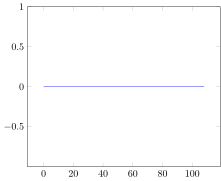

In [47]:
all_X = [X for X in model_gp.grid]
all_inds = collect(1:length(model_gp.grid))

μ, σ² = predict(model_gp, model_gp.X, model_gp.X_inds, model_gp.y, all_X, all_inds, model_gp.K)

function get_rates(μ, σ², δ)
    β = quantile(Normal(), δ)
    test_stats = μ .+ β .* sqrt.(σ²)
    is_safe = test_stats .< 0.1

    FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
    FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)

    return length(FN_inds), length(FP_inds)
end

δs = collect(range(0.5, 1, 100))
FNs = zeros(100)
FPs = zeros(100)

for (i, δ) in enumerate(δs)
    FNs[i], FPs[i] = get_rates(μ, σ², δ)
end

ax = Axis(Plots.Linear(FNs, FPs, mark="none"))

In [63]:
nsamps_tot = 100000
nsamps_indiv = 5000

ss_gp = []
for i = 1:5
    model_gp = pendulum_gp_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, nsamps=nsamps_indiv, ℓ=1e-1)
    set_sizes_gp = run_estimation!(model_gp, problem, MILE_acquisition, nsamps_tot)
    push!(ss_gp, set_sizes_gp)
end

0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
5.0%┣██▏                                        ┫ 1/20 [00:03<Inf:Inf, InfGs/it]
10.0%┣████▊                                          ┫ 2/20 [00:06<01:40, 6s/it]
15.0%┣███████                                        ┫ 3/20 [00:09<01:20, 5s/it]
20.0%┣█████████▍                                     ┫ 4/20 [00:14<01:12, 5s/it]
25.0%┣███████████▊                                   ┫ 5/20 [00:17<01:04, 4s/it]
30.0%┣██████████████                                 ┫ 6/20 [00:21<00:58, 4s/it]
35.0%┣████████████████▌                              ┫ 7/20 [00:24<00:52, 4s/it]
40.0%┣██████████████████▉                            ┫ 8/20 [00:28<00:48, 4s/it]
45.0%┣█████████████████████▏                         ┫ 9/20 [00:31<00:43, 4s/it]
50.0%┣███████████████████████                       ┫ 10/20 [00:35<00:39, 4s/it]
55.0%┣█████████████████████████▎                    ┫ 11/20 [00:39<00:35, 4s/it]
60.0%┣██████████████████████


50.0%┣███████████████████████                       ┫ 10/20 [00:36<00:39, 4s/it]
55.0%┣█████████████████████████▎                    ┫ 11/20 [00:39<00:35, 4s/it]
60.0%┣███████████████████████████▋                  ┫ 12/20 [00:43<00:31, 4s/it]
65.0%┣██████████████████████████████                ┫ 13/20 [00:46<00:27, 4s/it]
70.0%┣████████████████████████████████▏             ┫ 14/20 [00:50<00:23, 4s/it]
75.0%┣██████████████████████████████████▌           ┫ 15/20 [00:54<00:19, 4s/it]
80.0%┣████████████████████████████████████▉         ┫ 16/20 [00:57<00:15, 4s/it]
85.0%┣███████████████████████████████████████       ┫ 17/20 [01:01<00:11, 4s/it]
90.0%┣█████████████████████████████████████████▍    ┫ 18/20 [01:03<00:07, 4s/it]
95.0%┣███████████████████████████████████████████▊  ┫ 19/20 [01:07<00:04, 4s/it]
100.0%┣█████████████████████████████████████████████┫ 20/20 [01:10<00:00, 4s/it]
100.0%┣█████████████████████████████████████████████┫ 20/20 [01:10<00:00, 4s/it]
0.0%┣                      

In [64]:
ss_gp = hcat(ss_gp...)
μ_ssgp = mean(ss_gp, dims=2)[:]
σ_ssgp = std(ss_gp, dims=2)[:]

pred_higp = μ_ssgp .+ σ_ssgp
pred_logp = μ_ssgp .- σ_ssgp;

In [65]:
@save "/scratch/smkatz/multilevelest/pendulum_results/gp_baseline_5000.bson" ss_gp

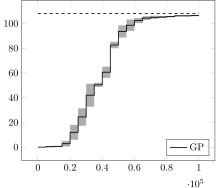

In [66]:
xmax = 100000
step = 1

end_ind = convert(Int64, floor(xmax / nsamps_indiv) + 1)
ax = Axis(Plots.Linear(collect(0:nsamps_indiv:xmax), pred_higp[1:end_ind], style="draw=none, mark=none, const plot, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:nsamps_indiv:xmax), pred_logp[1:end_ind], style="draw=none, mark=none, const plot, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[black!40, opacity=0.8, forget plot] fill between[of=A and B];"))
push!(ax, Plots.Linear(collect(0:nsamps_indiv:xmax), μ_ssgp[1:end_ind], mark="none",
    style="thick, black, const plot", legendentry="GP"))
push!(ax, Plots.Linear([0.0, xmax], [108.0, 108.0], mark="none", style="thick, black, dashed"))
ax.legendPos = "south east"
ax

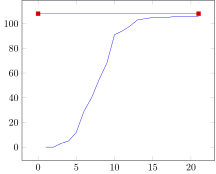

In [32]:
ax = Axis(Plots.Linear(set_sizes_gp, mark="none"))
push!(ax, Plots.Linear([0.0, length(set_sizes_gp)], [108.0, 108.0]))
ax

In [35]:
set_sizes_gp[end]

106

In [33]:
function compute_fpr(model::GaussianProcessModel, problem_gt::GriddedProblem)
    all_X = [X for X in model.grid]
    all_inds = collect(1:length(model.grid))
    μ, σ² = predict(model, model.X, model.X_inds, model.y, all_X, all_inds, model.K)
    β = quantile(Normal(), problem_gt.conf_threshold)
    is_safe = (μ .+ β .* sqrt.(σ²)) .< problem_gt.pfail_threshold

    FP_inds = findall(is_safe .& .!problem_gt.is_safe)
    return isnothing(FP_inds) ? 0.0 : length(FP_inds) / length(is_safe)
end

compute_fpr (generic function with 1 method)

In [34]:
compute_fpr(model_gp, problem_gt_small)

0.0

In [25]:
nsamps = 5000
cv = √((1 - 0.1) / (0.1 * nsamps))
0.1 * cv

0.004242640687119286

In [22]:
safe_pfails = model_gt_small.pfail[findall(problem_gt_small.is_safe)]

108-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0007
 0.0062
 0.0232
 ⋮
 0.0319
 0.0344
 0.0487
 0.0642
 0.0881
 0.0642
 0.0699
 0.0787
 0.0944

In [23]:
sort(safe_pfails)

108-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0713
 0.0725
 0.0737
 0.0758
 0.0787
 0.0848
 0.0881
 0.0944
 0.0949

# Rates for bandit model

In [56]:
function pendulum_bandit_model(nθ, nω; σθ_max=0.2, σω_max=1.0)
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    return BanditModel(grid)
end

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

# ss_b = []
# for i = 1:5
    model_b = pendulum_bandit_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max)
    dkwucb_acquisition(model) = dkwucb_acquisition(model, problem.pfail_threshold, problem.conf_threshold)
    set_sizes_b = run_estimation!(model_b, problem, dkwucb_acquisition, 5000)
#     push!(ss_b, set_sizes_b)
# end

0.0%┣                                            ┫ 0/5.0k [00:00<-4:-10, -0s/it]
0.0%┣                                         ┫ 1/5.0k [00:00<Inf:Inf, InfGs/it]
1.1%┣▌                                          ┫ 55/5.0k [00:00<00:09, 527it/s]
2.3%┣█                                         ┫ 117/5.0k [00:00<00:06, 758it/s]
3.6%┣█▌                                        ┫ 179/5.0k [00:00<00:06, 873it/s]
4.7%┣██                                        ┫ 237/5.0k [00:00<00:05, 928it/s]
5.2%┣██▏                                       ┫ 260/5.0k [00:00<00:06, 849it/s]
6.5%┣██▊                                       ┫ 326/5.0k [00:00<00:05, 914it/s]
8.0%┣███▍                                      ┫ 399/5.0k [00:00<00:05, 980it/s]
9.2%┣███▉                                     ┫ 462/5.0k [00:00<00:04, 1.0kit/s]
10.3%┣████                                    ┫ 513/5.0k [00:01<00:04, 1.0kit/s]
11.2%┣████▌                                   ┫ 561/5.0k [00:01<00:04, 1.0kit/s]
12.2%┣█████                 

▌      ┫ 4.2k/5.0k [00:04<00:01, 986it/s]
85.0%┣██████████████████████████████████      ┫ 4.3k/5.0k [00:04<00:01, 989it/s]
86.1%┣██████████████████████████████████▌     ┫ 4.3k/5.0k [00:04<00:01, 990it/s]
87.2%┣███████████████████████████████████     ┫ 4.4k/5.0k [00:04<00:01, 991it/s]
88.3%┣███████████████████████████████████▍    ┫ 4.4k/5.0k [00:04<00:01, 992it/s]
89.4%┣███████████████████████████████████▊    ┫ 4.5k/5.0k [00:05<00:01, 993it/s]
90.4%┣████████████████████████████████████▏   ┫ 4.5k/5.0k [00:05<00:00, 993it/s]
90.9%┣████████████████████████████████████▍   ┫ 4.5k/5.0k [00:05<00:00, 988it/s]
92.2%┣████████████████████████████████████▉   ┫ 4.6k/5.0k [00:05<00:00, 990it/s]
93.4%┣█████████████████████████████████████▍  ┫ 4.7k/5.0k [00:05<00:00, 992it/s]
94.5%┣█████████████████████████████████████▉  ┫ 4.7k/5.0k [00:05<00:00, 994it/s]
95.6%┣██████████████████████████████████████▎ ┫ 4.8k/5.0k [00:05<00:00, 995it/s]
96.7%┣██████████████████████████████████████▊ ┫ 4.8k/5.0k [00:05<00

5001-element Vector{Int64}:
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  ⋮
 86
 86
 86
 86
 86
 86
 86
 86
 86

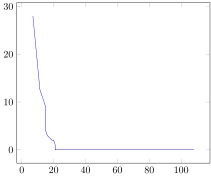

In [59]:
function get_rates(model, δ)
    test_stats = [quantile(Beta(α, β), δ) for (α, β) in zip(model.α, model.β)]
    is_safe = test_stats .< 0.1

    FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
    FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)

    return length(FN_inds), length(FP_inds)
end

δs = collect(range(0.1, 1, 100))
FNs = zeros(100)
FPs = zeros(100)

for (i, δ) in enumerate(δs)
    FNs[i], FPs[i] = get_rates(model_b, δ)
end

ax = Axis(Plots.Linear(FNs, FPs, mark="none"))